<img src="../img/Logo.png" width="300">

# Ejercicio
## Aprendizaje de imágenes - Ejercicio de reconocimiento facial

### Profesor: Jorge Calvo

In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Descarga de datos 
* **fetch_lfw_people** <br>
Este conjunto de datos es una colección de imágenes JPEG de personajes famosos recopiladas a través de Internet; todos los detalles están disponibles en el sitio web oficial:

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

In [70]:
Data = fetch_lfw_people(color=True, min_faces_per_person=3,resize=0.6)

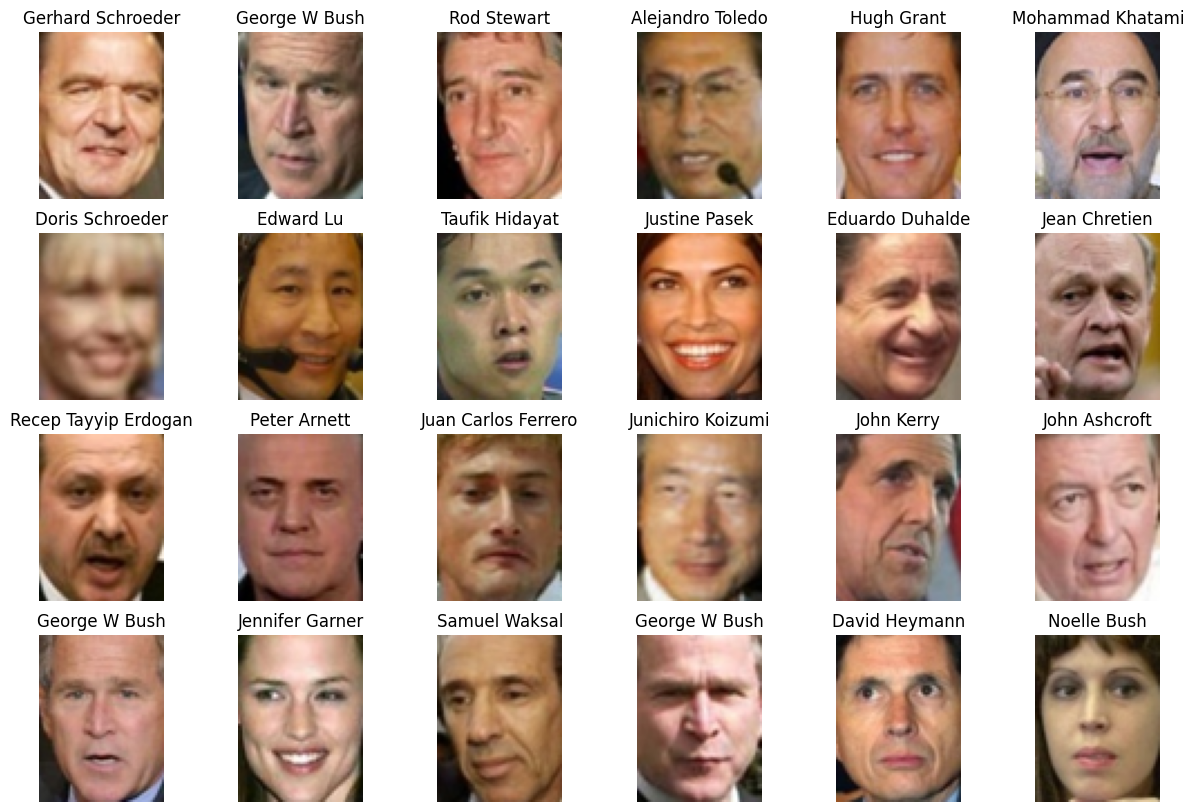

In [71]:
#Visualización de los datos
from IPython.core.pylabtools import figsize

fig, ax = plt.subplots(4, 6, figsize=(15,10))
for i, axi in enumerate(ax.flat):
    axi.set_title(Data.target_names[Data.target[i]])
    axi.axis("off")
    axi.imshow(Data.images[i])

In [72]:
Data.images.shape

(7606, 75, 56, 3)

In [73]:
# Obtener las imágenes y los targets
images = Data.images
targets = Data.target

print(images.shape)

# Obtener el número de clases y de imágenes
n_classes = len(Data.target_names)

# Convertir las imágenes a arrays de tipo float32 y normalizar entre 0 y 1
images = images.astype('float32') / 255.0

print(targets)

(7606, 75, 56, 3)
[280 278 737 ... 111 900 857]


### Dividir los datos en entrenamiento y validación
La librería **train_test_split** en Python, específicamente en la librería scikit-learn, proporciona una funcionalidad conveniente para dividir un conjunto de datos en conjuntos de entrenamiento y prueba de manera aleatoria.

La función train_test_split se utiliza comúnmente en el ámbito del aprendizaje automático (machine learning) para dividir los datos en dos partes: un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento se utiliza para entrenar el modelo de aprendizaje automático, mientras que el conjunto de prueba se utiliza para evaluar el rendimiento del modelo una vez entrenado.

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

Donde **X** representa las características de los datos y **y** representa las etiquetas o variables objetivo asociadas. **test_size** es el porcentaje de datos que se utilizarán para el conjunto de prueba (por ejemplo, 0.2 para un 20% de los datos) y **random_state** es una semilla que se utiliza para reproducir los resultados.

In [74]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42, stratify=targets)

In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Aumento de datos para mejorar la generalización
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [76]:
def create_kernel_r(num_arrays):
    kernel=[]
    c=2
    #array = np.random.randint(-1,1,size=(3, 3))
    for _ in range(num_arrays):
        array= np.array([[c, c, -1], [0, c, -1], [c, 1, -1]])
        kernel.append(array)
        c=random.randint(-1,1)
    return kernel

n_kernels= 32*3
size_kernel= (3,3)
kernels=create_kernel_r(n_kernels)

In [77]:
cosh = (lambda x: (np.e**(x) + np.e**(-x))/2) #Saco la función de coseno hiperbólico para la derivada de la tangh
tanh = (lambda x: (np.e**(x) - np.e**(-x))/(np.e**(x) + np.e**(-x)))
sigm = (lambda x:1/(1+np.e**(-x)))
relu = (lambda x: np.maximum(0,x))
lrelu = (lambda x: np.maximum(0.01*x,x))
swish = (lambda x : x*sigm(x))

In [82]:
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models, callbacks

# Definir la arquitectura de la red neuronal convolucional
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(images.shape[1], images.shape[2], images.shape[3]), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.1),
    
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax')
])

# Definir un optimizador Adam con learning rate específico
adam_optimizer = optimizers.Adam(learning_rate=0.0003)

# Compilar el modelo con el optimizador personalizado
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping para evitar sobreajuste
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Resumen del modelo
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 75, 56, 32)        896       
                                                                 
 batch_normalization_76 (Ba  (None, 75, 56, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 37, 28, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 37, 28, 32)        9248      
                                                                 
 batch_normalization_77 (Ba  (None, 37, 28, 32)        128       
 tchNormalization)                                               
                                                     

In [84]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Precisión en el conjunto de prueba: {test_acc:.4f}')


48/48 - 0s - loss: 11.9109 - accuracy: 0.0664 - 450ms/epoch - 9ms/step
Precisión en el conjunto de prueba: 0.0664


238/238 [==============================] - 5s 19ms/step


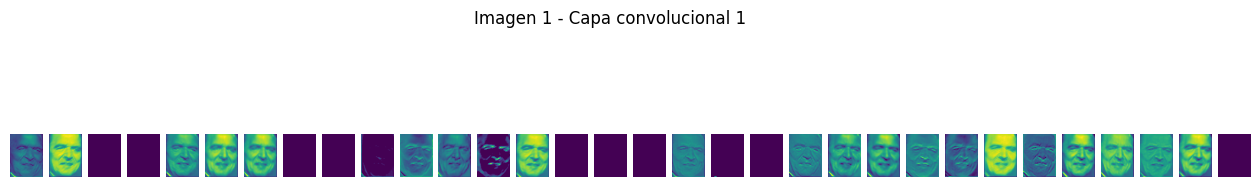

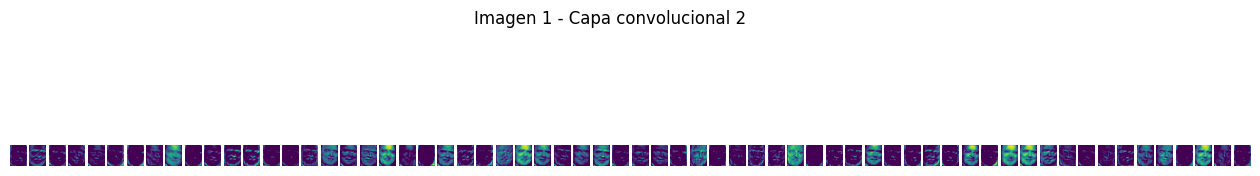

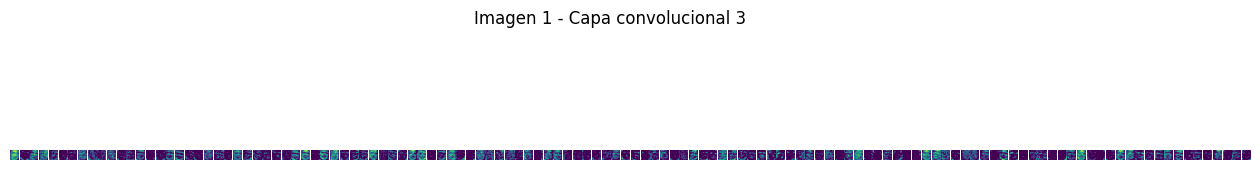

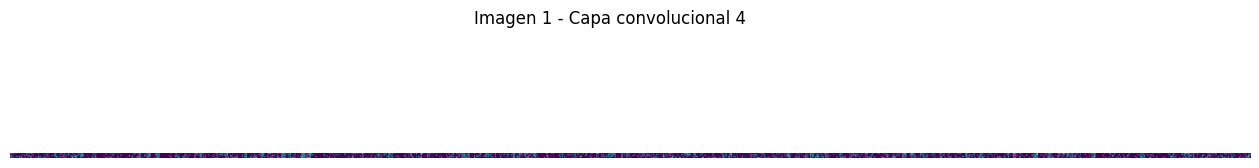

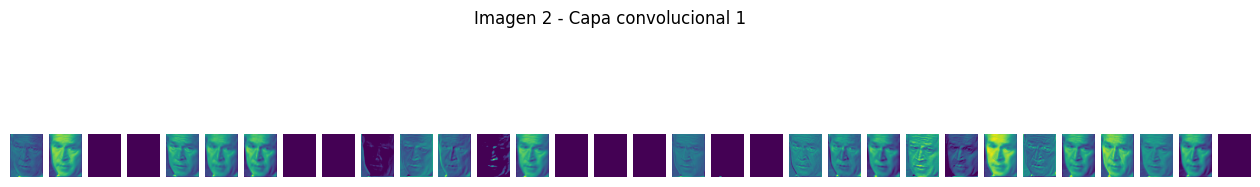

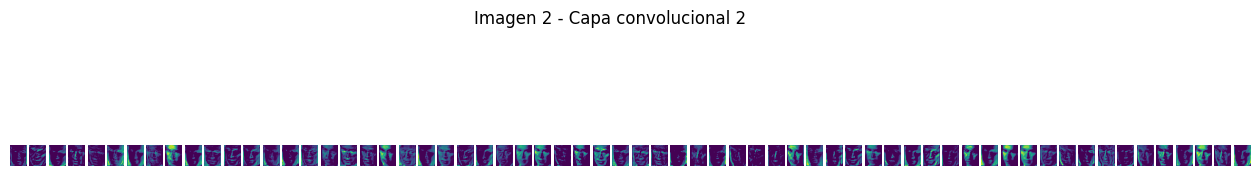

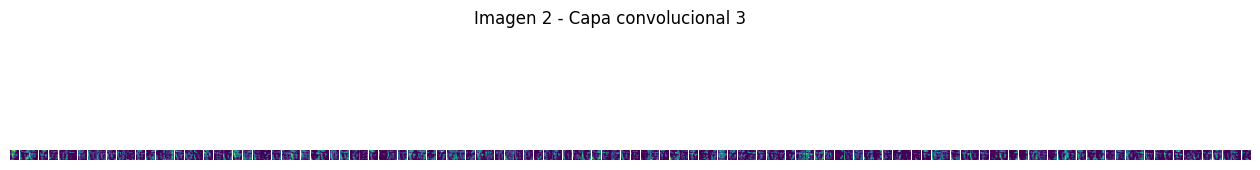

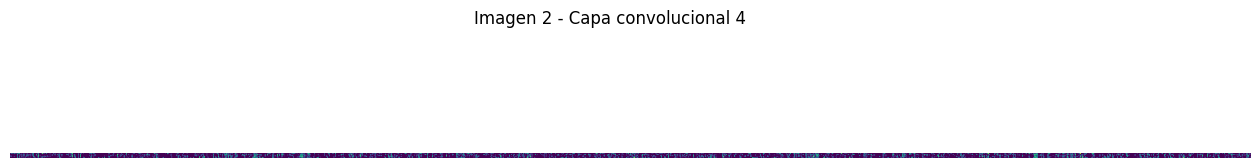

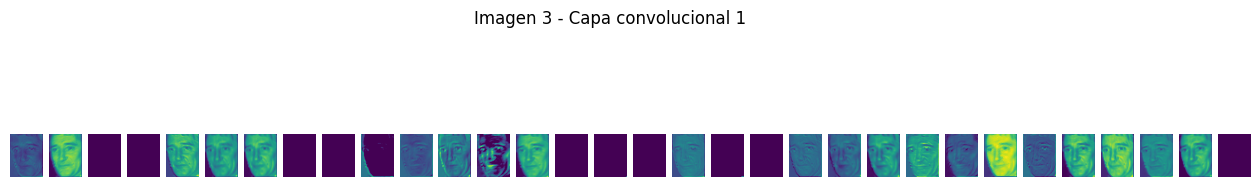

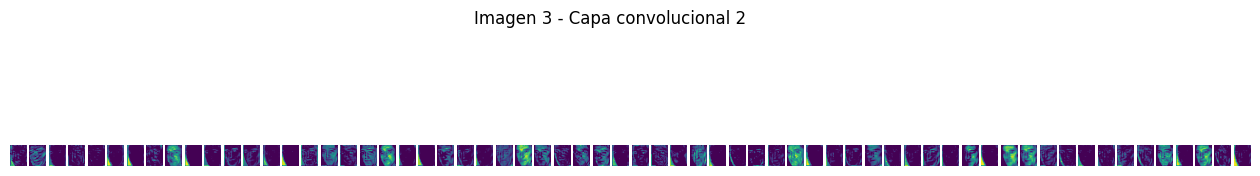

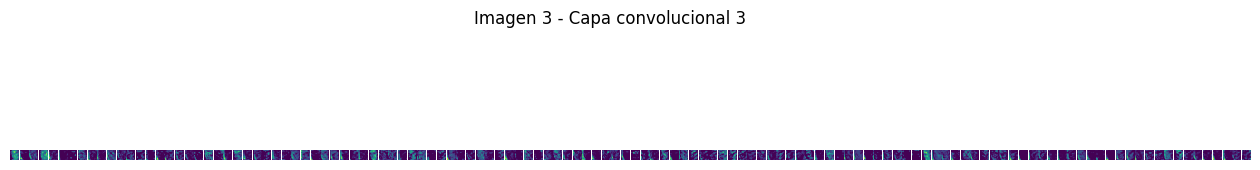

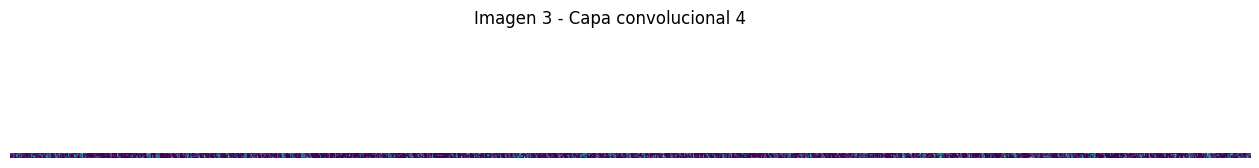

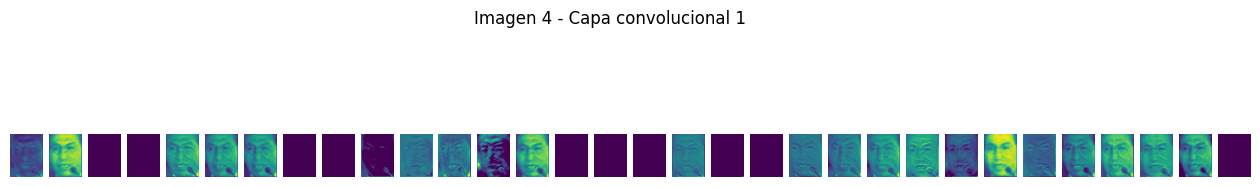

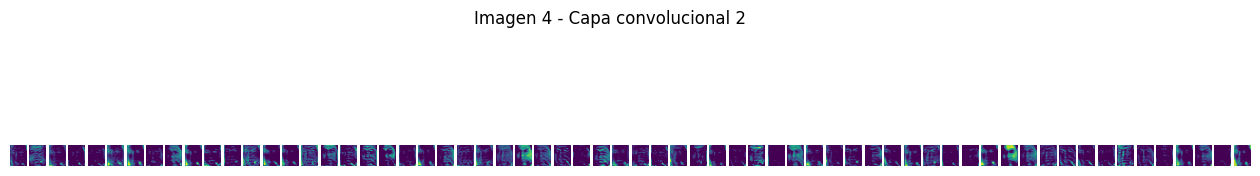

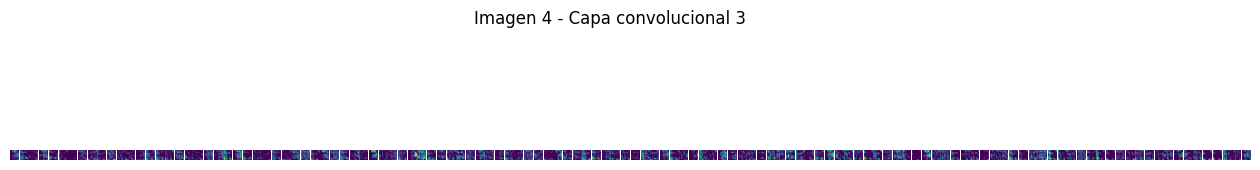

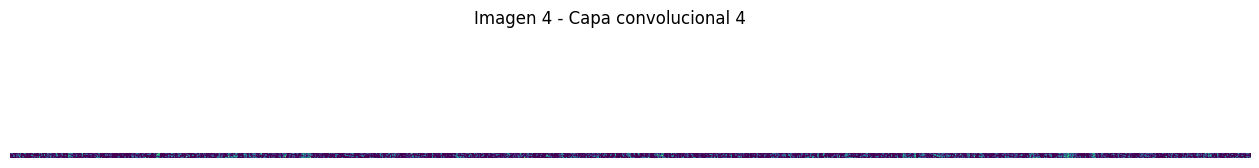

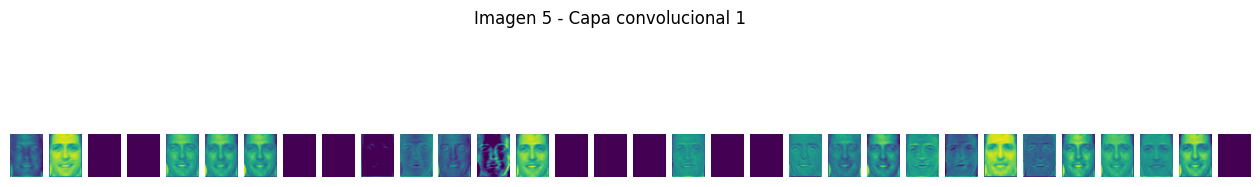

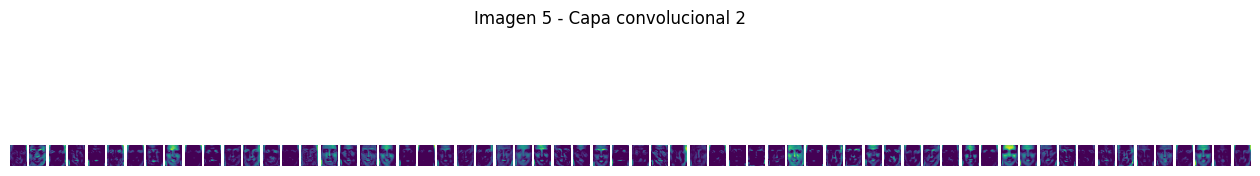

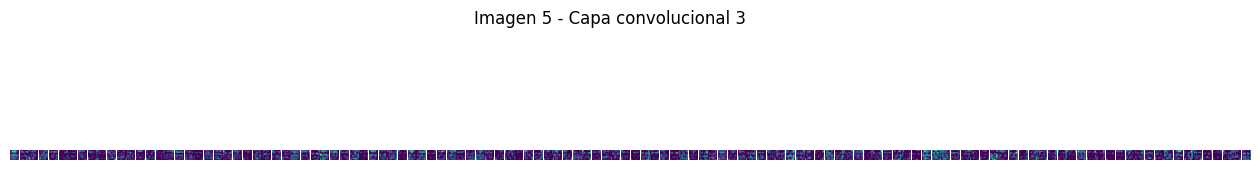

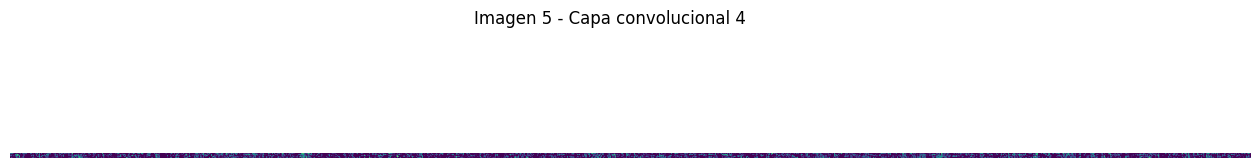

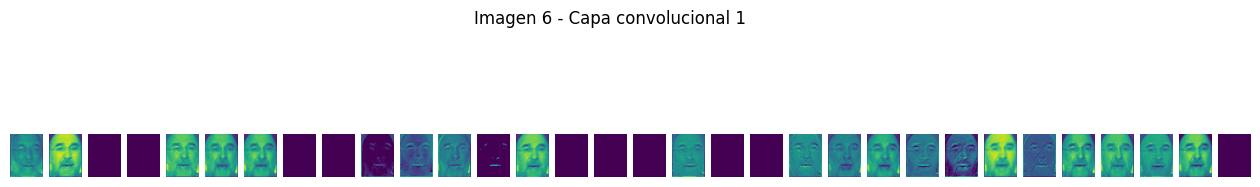

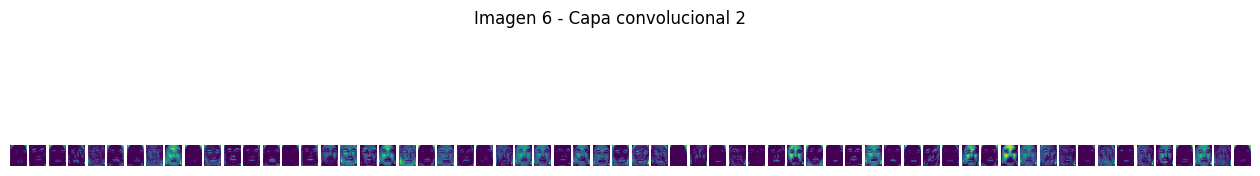

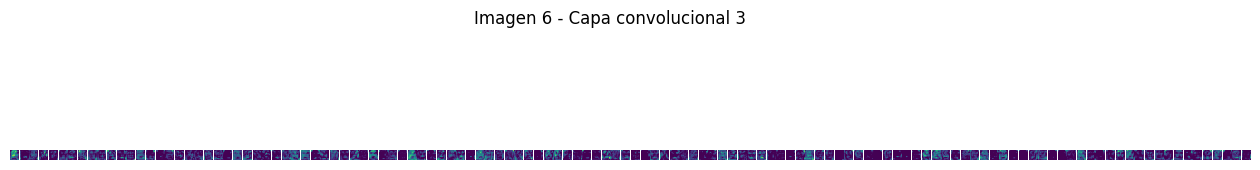

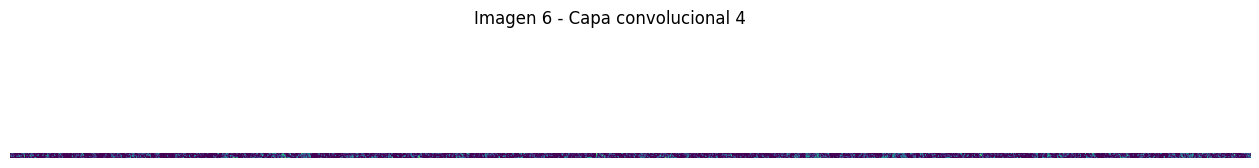

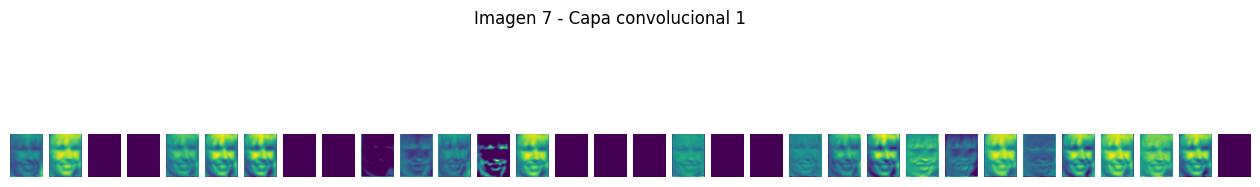

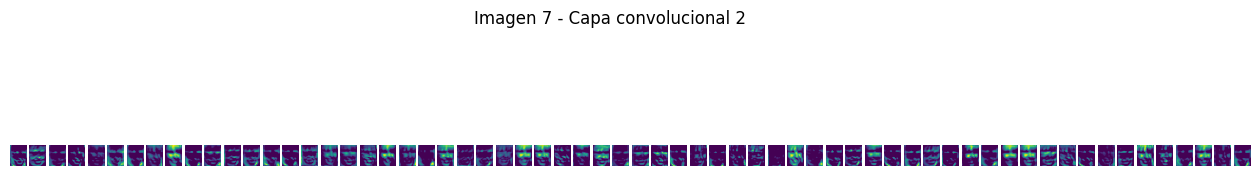

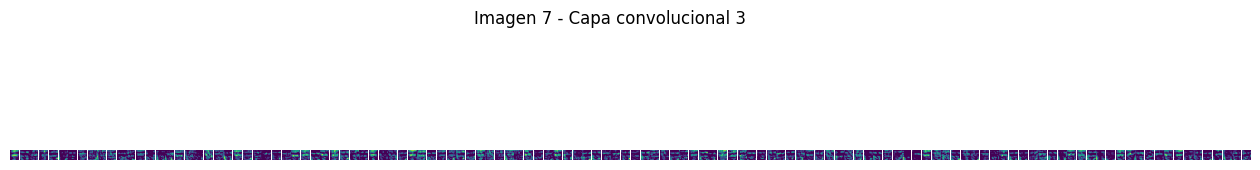

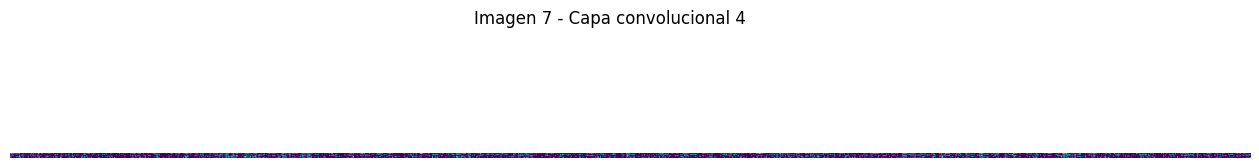

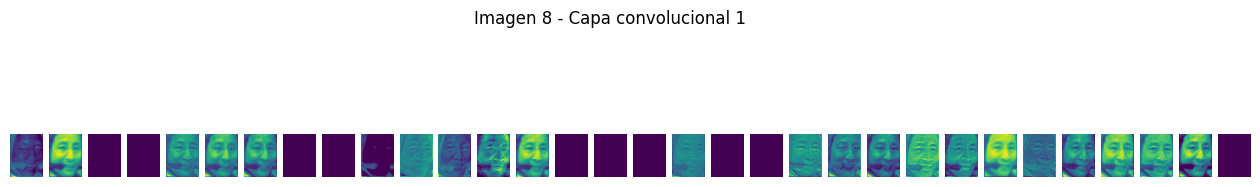

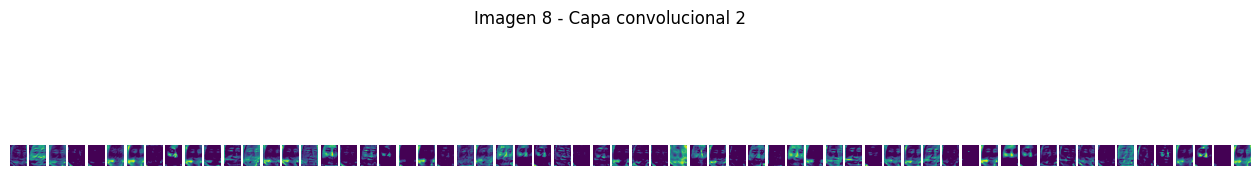

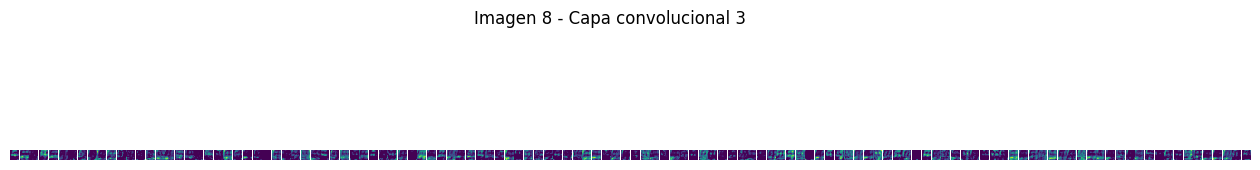

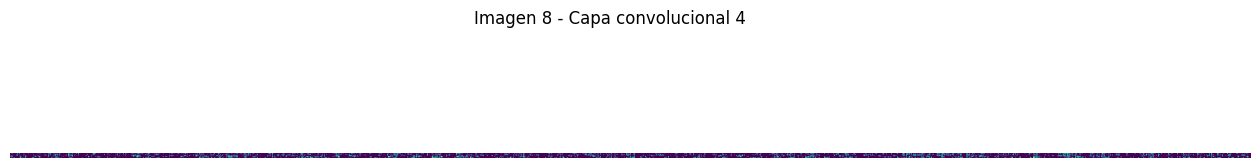

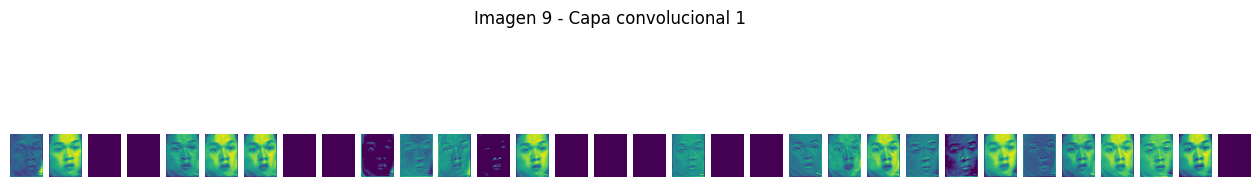

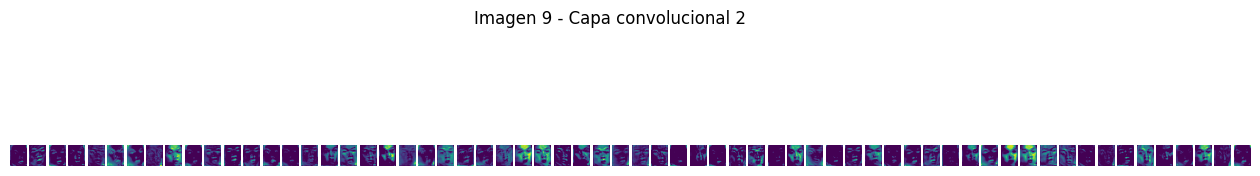

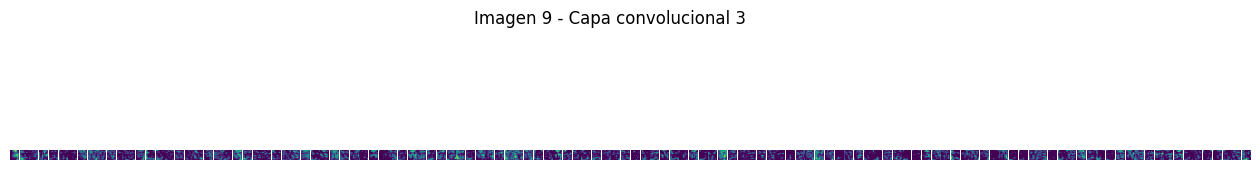

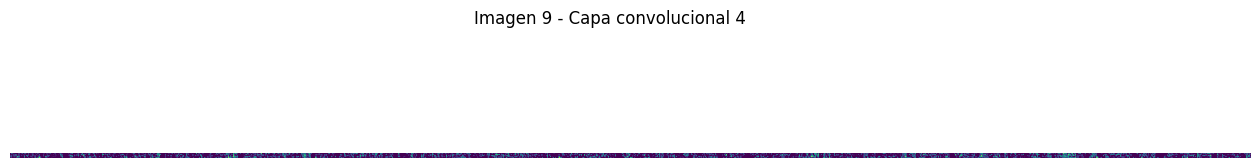

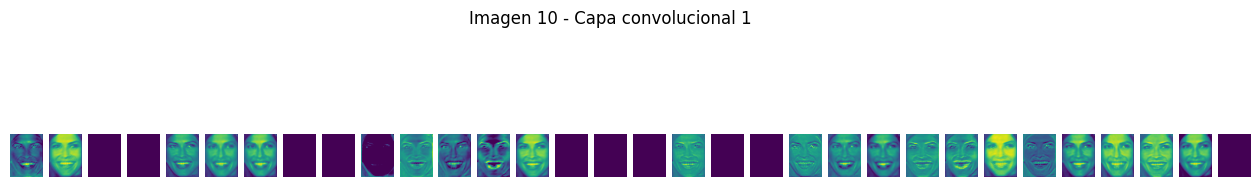

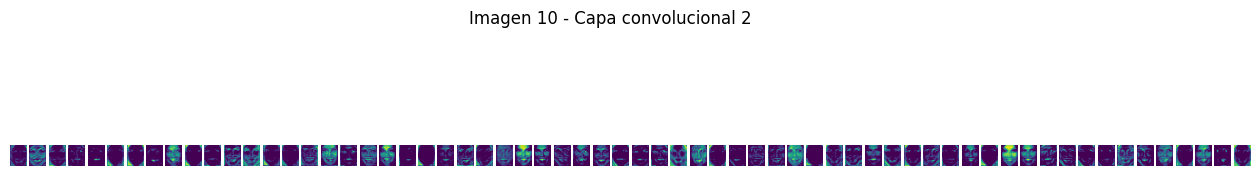

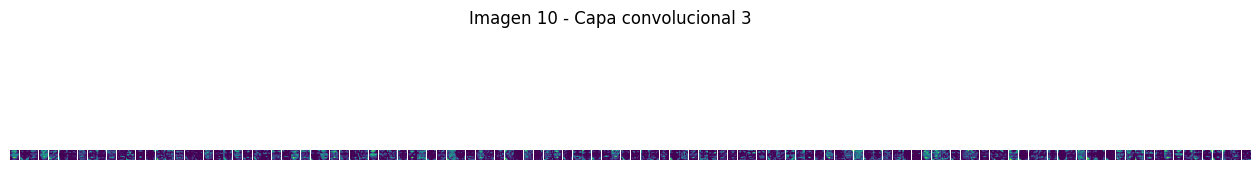

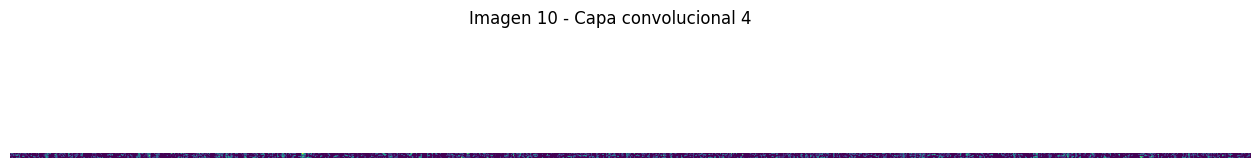

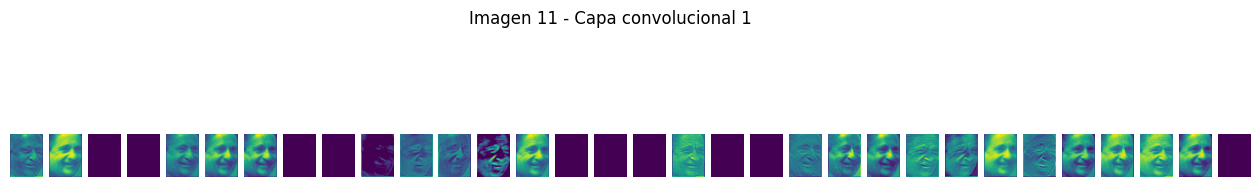

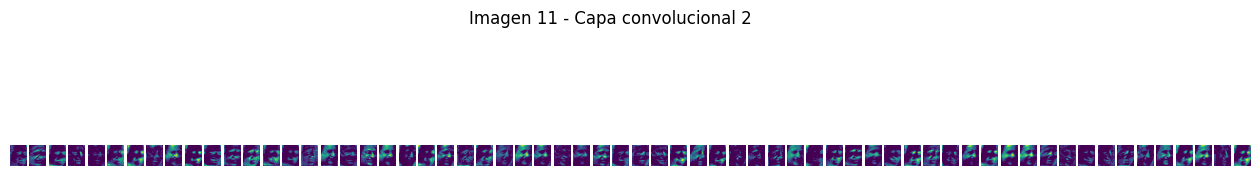

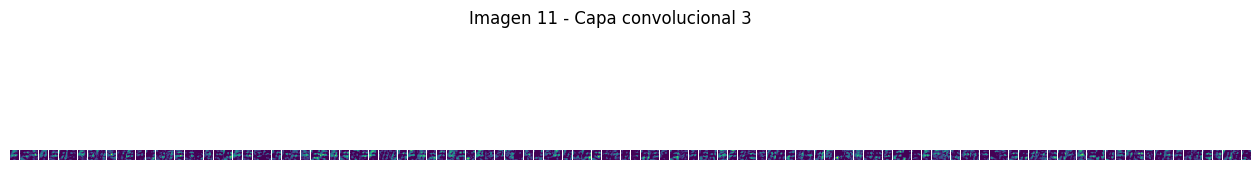

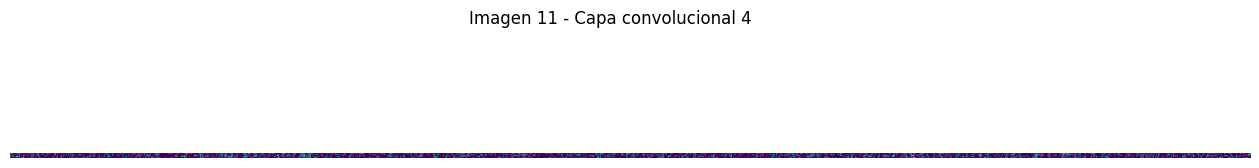

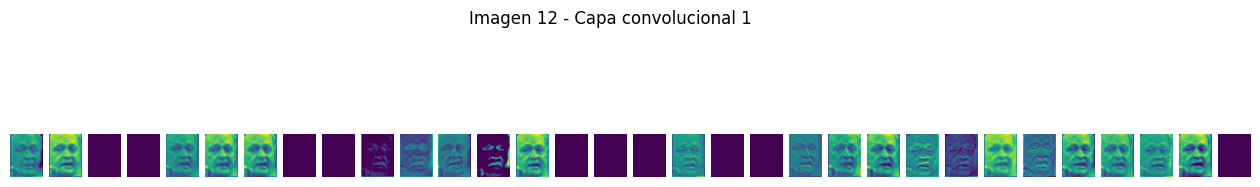

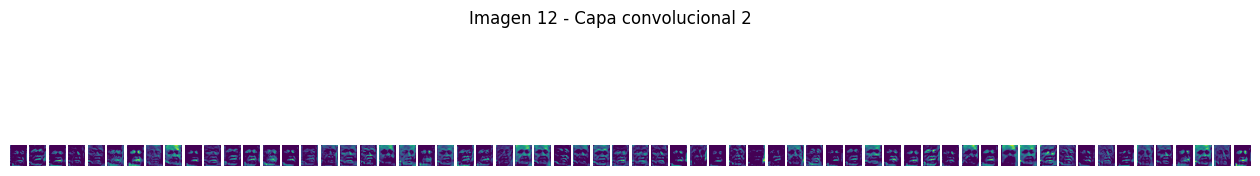

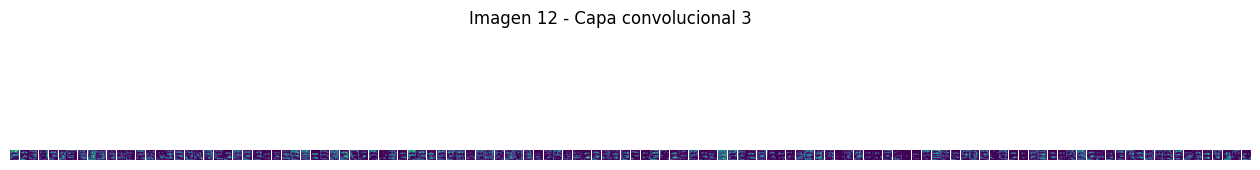

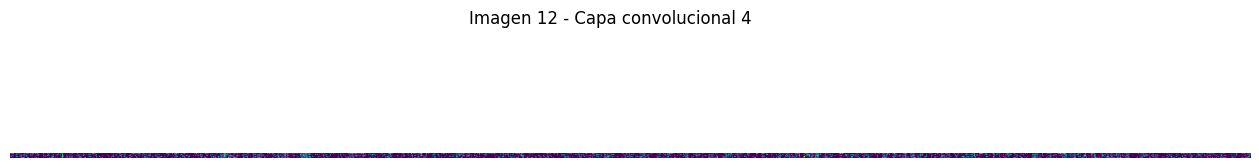

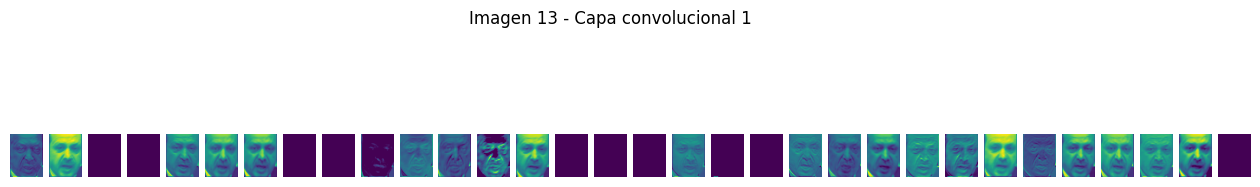

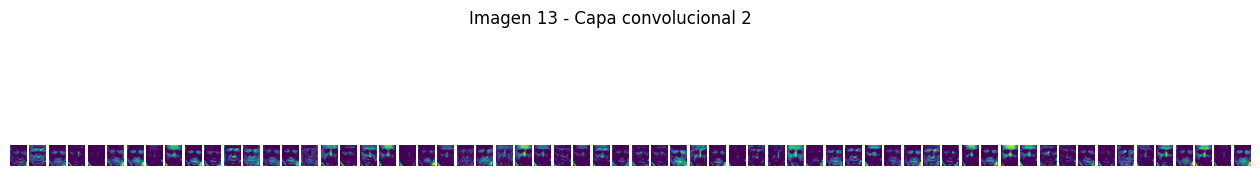

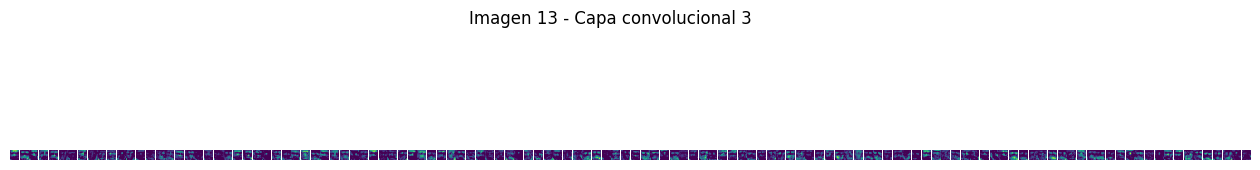

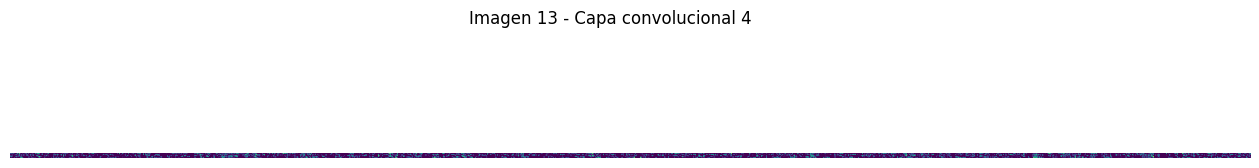

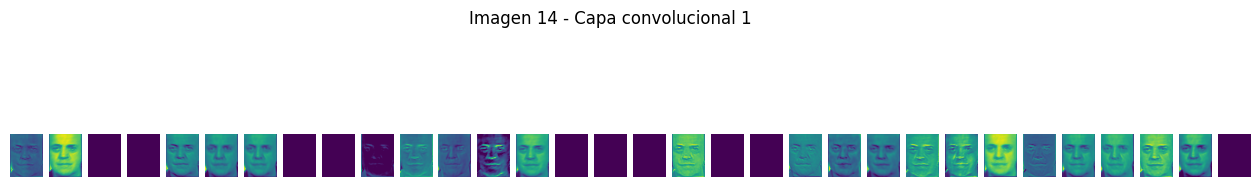

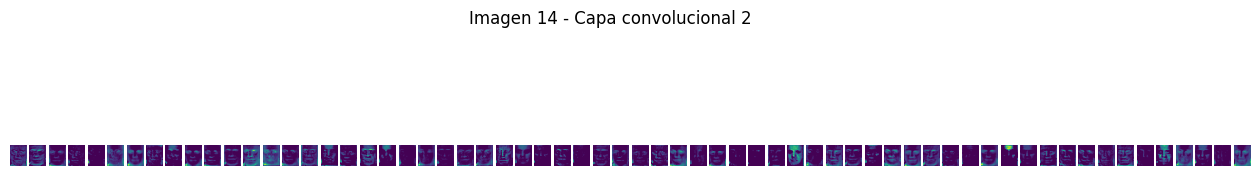

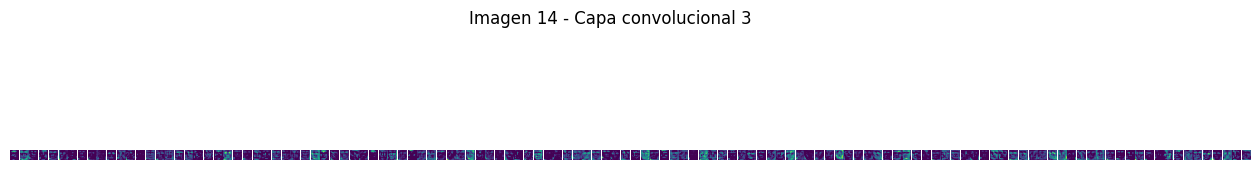

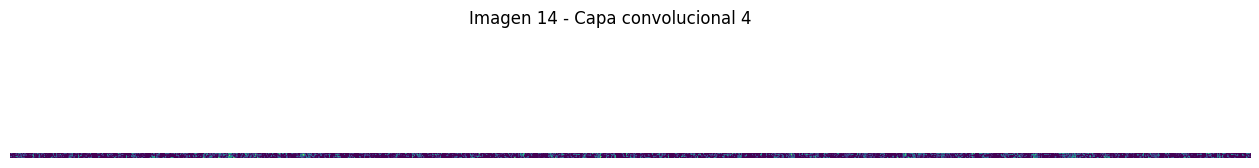

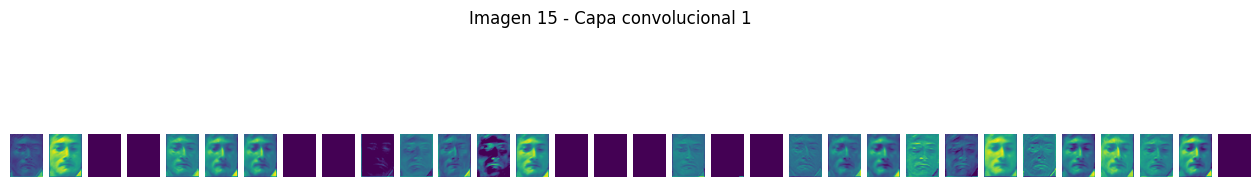

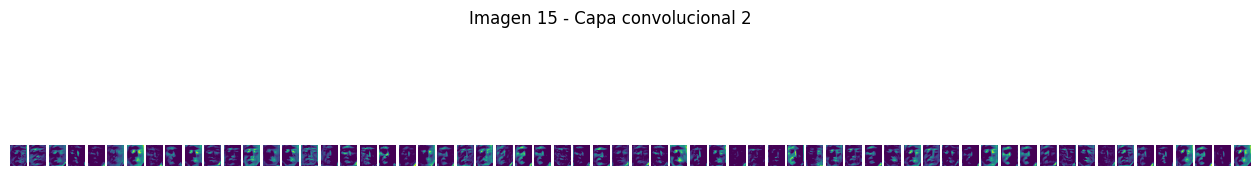

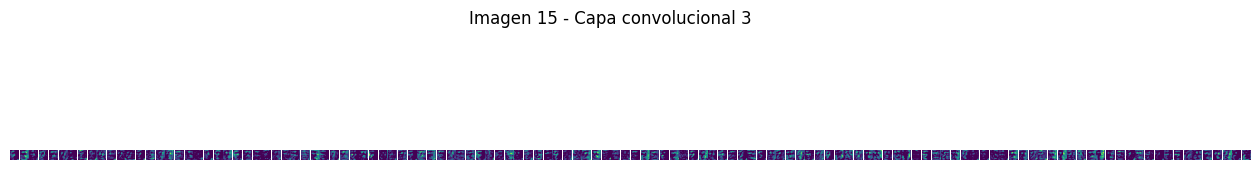

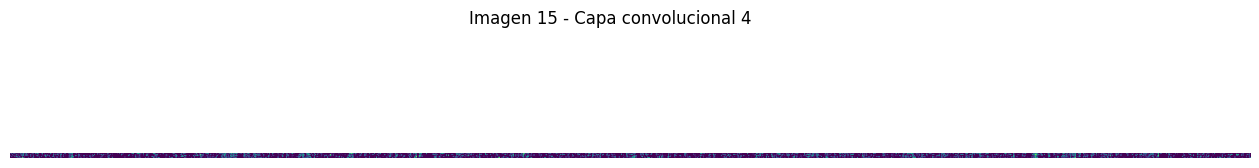

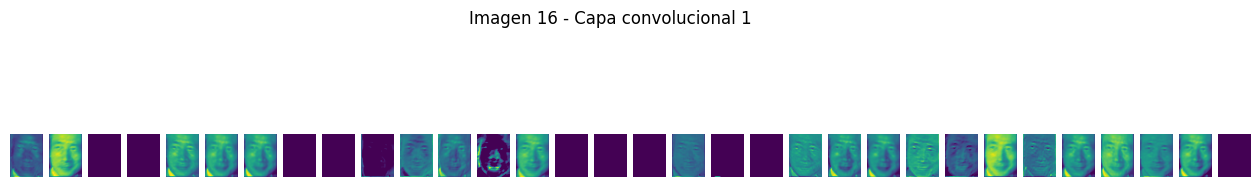

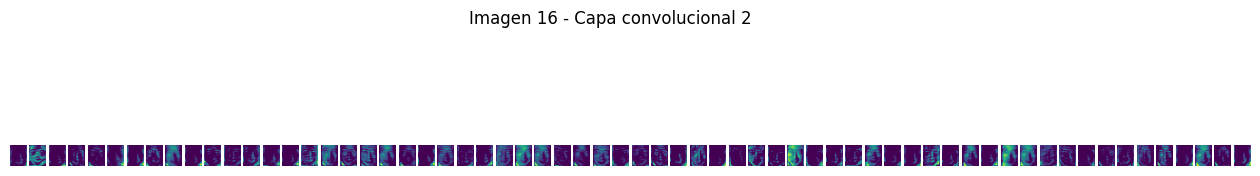

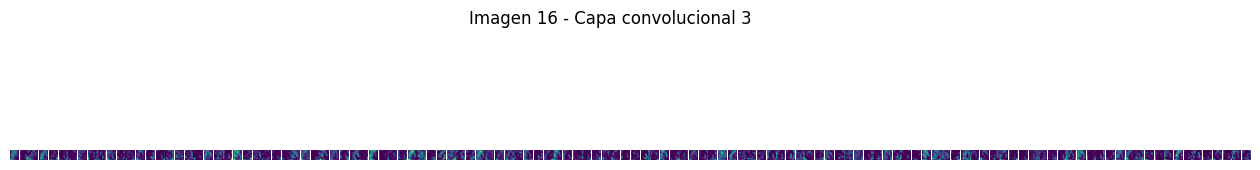

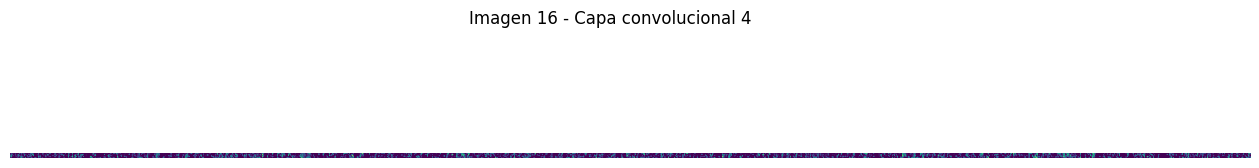

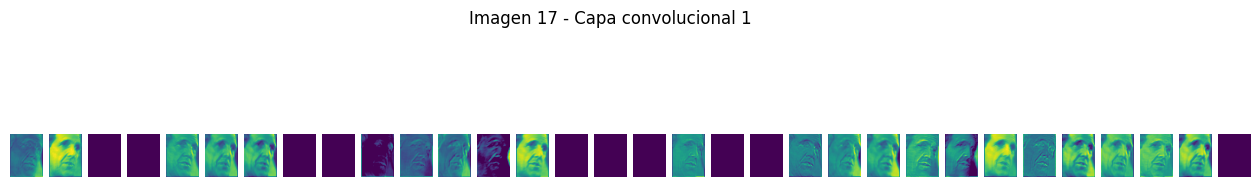

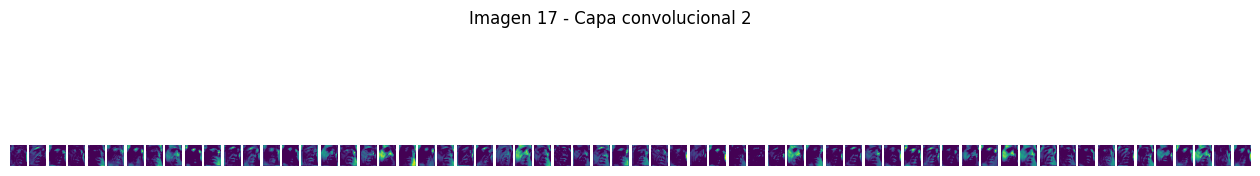

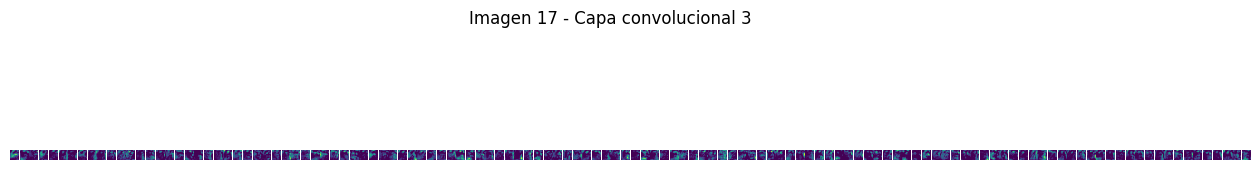

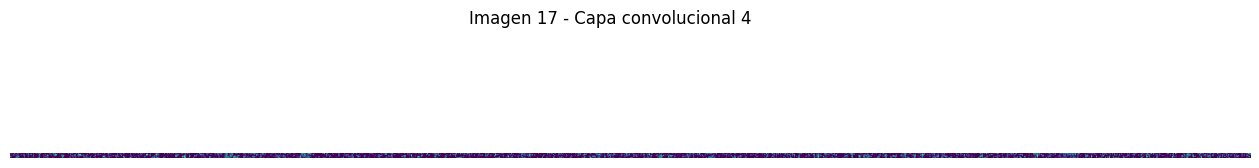

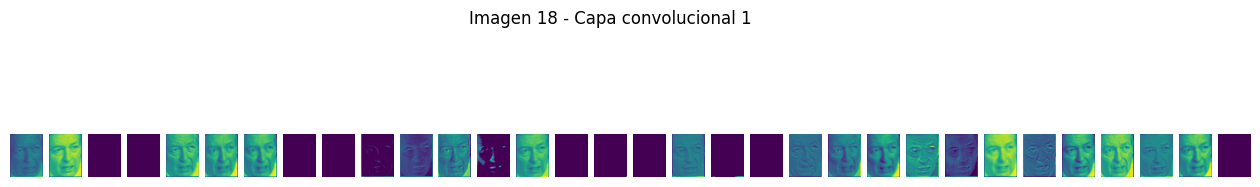

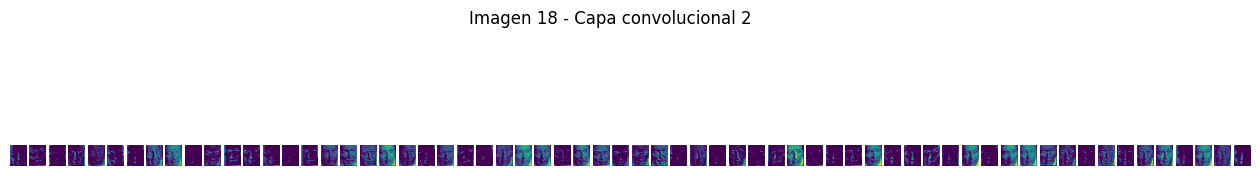

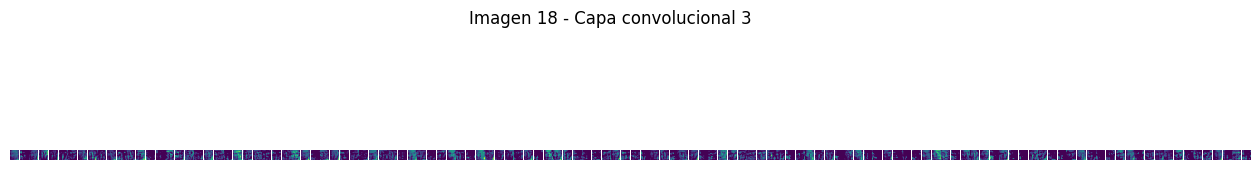

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x3117c58b0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x311d30e50> (for post_execute):


KeyboardInterrupt: 

In [47]:
# Obtener las salidas de las capas convolucionales
conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
conv_outputs = [layer.output for layer in conv_layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=conv_outputs)
activations = activation_model.predict(images)

# Visualizar las características de cada capa convolucional para cada imagen
for i in range(len(images)):
    for j, activation in enumerate(activations):
        fig, axes = plt.subplots(1, activation.shape[-1], figsize=(16, 3))
        fig.suptitle('Imagen {} - Capa convolucional {}'.format(i+1, j+1))
        
        for k, ax in enumerate(axes.flat):
            ax.imshow(activation[i, :, :, k])
            ax.axis('off')
        
        plt.show()